In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import sys

sys.path.append('../..')

from heat_load_calc.initializer import window

# oblique_incidence_charac

## Outline

窓の入射角特性を計算する。

## Interface

### 直達日射

#### 仕様

get_tau_d_j_ns(theta_aoi_j_ns, glazing_type_j)

params:  

| パラメータ名　| 型 | 単位 | 概要 |
| :--- | :--- | :--- | :-- |
| theta_aoi_j_ns | np.ndarray[float] | rad | プロファイル角 |
| glazing_type_j | str | - | ガラスのタイプ（'single' or 'multiple'） |

returns:

np.ndarray


直達日射に対する基準化透過率を返します。
それぞれのタプルはnumpy形式で、1年間のステップ数の配列になっています。


| 名称 | 単位 | 概要 |
| :--- | :--- | :--- |
| 直達日射に対する基準化透過率 | - | 直達日射に対する基準化透過率。1年間のステップ数分の配列。np.ndarray 形式。 |

#### Example

In [2]:
window.get_tau_d_j_ns(theta_aoi_j_ns=0.0, glazing_type_j='single')

0.9990000000000014

In [3]:
window.get_tau_d_j_ns(theta_aoi_j_ns=0.0, glazing_type_j='multiple')

0.9980010000000029

### 天空放射

#### 仕様

get_c_d_j(glazing_type_j)

params:

| パラメータ名　| 型 | 単位 | 概要 |
| :--- | :--- | :--- | :-- |
| glazing_type_j | str | - | ガラスのタイプ（'single' or 'multiple'） |

returns:

天空日射に対する基準化透過率を返します。


| 名称 | 単位 | 概要 |
| :--- | :--- | :--- |
| 透明な開口部の拡散日射に対する基準化透過率 | - | 透明な開口部の拡散日射に対する基準化透過率。 |




In [4]:
window.get_c_d_j(glazing_type_j='single')

0.9

In [5]:
window.get_c_d_j(glazing_type_j='multiple')

0.832

## basics

### 直達日射に対する規準化透過率

直達日射に対する規準化透過率（単層ガラス）

$$ f_{ang, single} = 0.0 \cdot (\cos \theta) ^ 0 + 2.552 \cdot (\cos \theta) + 1.364 \cdot (\cos \theta) ^ 2 - 11.388 \cdot (\cos \theta) ^ 3 + 13.617 \cdot (\cos \theta) ^ 4 - 5.146 \cdot (\cos \theta) ^ 5 $$

直達日射に対する規準化反射率（単層ガラス）

$$ \rho_{ang, single} = 1.0 * (\cos \theta) ** 0 - 5.189 * (\cos \theta) + 12.392 * (\cos \theta) ^ 2 - 16.593 * (\cos \theta) ^ 3 + 11.851 * (\cos \theta) ^ 4 - 3.461 * (\cos \theta) ^ 5 $$

直達日射に対する規準化透過率（複層ガラス）

$$ f_{ang} = \frac{f_{ang, single} ^ 2}{1.0 - \rho_{ang,single} ^ 2} $$

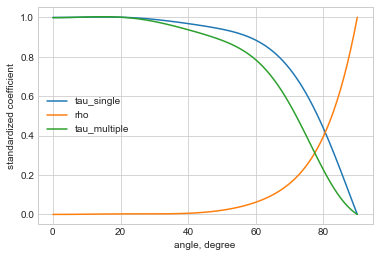

In [6]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

phi = np.arange(start= 0.0, stop= 91.0, step = 1.0)
ax.plot(phi, window.get_tau_d_j_ns(np.radians(phi), 'single'), label='tau_single')
ax.plot(phi, window._get_rhod_n_single(np.radians(phi)), label='rho')
ax.plot(phi, window.get_tau_d_j_ns(np.radians(phi), 'multiple'), label='tau_multiple')

ax.set_xlabel('angle, degree')
ax.set_ylabel('standardized coefficient')

plt.legend()
plt.show()

負荷計算での別知見

In [7]:
def get_tau_satoh(phi: float) -> float:
    """
    Args:
        phi: 入射角, radian
    Returns:
        入射角に対する基準化透過率
    """
    cos_phi = np.cos(phi)
    return (2.392 * cos_phi - 3.8636 * cos_phi ** 3 + 3.7568 * cos_phi ** 5 - 1.3965 * cos_phi ** 7) / 0.88

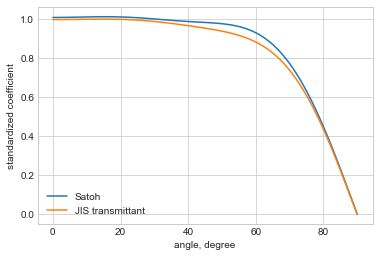

In [8]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

phi = np.arange(start= 0.0, stop= 91.0, step = 1.0)
ax.plot(phi, get_tau_satoh(np.radians(phi)), label='Satoh')
ax.plot(phi, window.get_tau_d_j_ns(np.radians(phi), 'single'), label='JIS transmittant')


ax.set_xlabel('angle, degree')
ax.set_ylabel('standardized coefficient')

plt.legend()
plt.show()

### 天空放射に対する規準化透過率

$$ \frac{ \int_0^{\frac{\pi}{2}} \tau(\theta) \cdot 2 \pi \sin \theta \cdot \cos \theta \cdot d \theta }{ \int_0^{\frac{\pi}{2}} 2 \pi \sin \theta \cdot \cos \theta \cdot d \theta } = \frac{ \int_0^{\frac{\pi}{2}} \tau(\theta) \cdot 2 \pi \sin \theta \cdot \cos \theta \cdot d \theta }{ \pi } = \int_0^{\frac{\pi}{2}} \tau(\theta) \cdot \sin 2 \theta \cdot d \theta $$

In [9]:
def get_tau_integral(tau_function: Callable[[float], float], n: int) -> float:

    delta_theta = np.pi / 2 /n

    thetas = np.arange(start=0, stop=np.pi/2, step=delta_theta)
    
    delta_tau = tau_function(thetas) * np.sin(2 * thetas) * delta_theta
    
    return delta_tau.sum()

単層ガラス

In [10]:
get_tau_integral(lambda tau: window.get_tau_d_j_ns(tau, 'single'), n=1000)

0.8968472082254145

In [11]:
window.get_c_d_j(glazing_type_j='single')

0.9

複層ガラス

In [12]:
get_tau_integral(lambda tau: window.get_tau_d_j_ns(tau, 'multiple'), n=1000)

0.8324284946266829

In [13]:
window.get_c_d_j(glazing_type_j='multiple')

0.832

単層ガラス（参考）

In [14]:
get_tau_integral(get_tau_satoh, n=1000)

0.9230277232289603

### 拡散光に対する基準化透過率の計算

#### 単層ガラス

In [ ]:
get_tau_integral(lambda tau: window.get_tau_d_j_ns(tau, 'single'), n=1000)